In [6]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, NUTS, MCMC

### Bayesian Modeling of Binary Data - Logistic Regression

$$logit(p) = f(x, \theta)$$

- p: the probability that some event occurs
- x: a vector of covariates
- logit transformation: widely used to transform between probability (0,1) and the entire real line
- inverse logit: expit function

This is the AE incidence example in MI255 Lec1/Lab1, where it is observed whether or not an AE occurs in each of the 100 patients and the probability of an AE is modeled as: 
$$AE_i \sim Bernoulli(p_{AE,i})$$
$$logit(p_{AE,i}) = \theta_1 + \theta_2 * dose_i + \theta_3 * age_i + \theta_4 * weight_i + \theta_5 * gender_i$$

STUDY DESIGN:
- parallel dose-finding study
- 100 subjects per dose cohort
- dose steps: 5, 10, 20, 40 mg
- possible covariates: age, weight, gender

Given that we have little prior information, a bivariate normal distribution with relatively large variances and no correlation is used as prior.

$$\theta_i \propto N(\mu = 0, \Sigma = 10^6)$$

In [3]:
## load the data
data = pd.read_csv('data/aedata.csv')
data.head()

,subject,weight,age,gender,dose,p.ae,ae
0,1,105.797393,43.391151,0,5,0.056688,0
1,2,102.272550,33.774902,1,5,0.019081,0
2,3,72.793006,38.951207,0,5,0.073184,0
3,4,62.560915,38.543048,0,5,0.082739,0
4,5,57.521840,38.640690,1,5,0.046299,0


In [4]:
## the AE nonoccurance / occurance in each dose cohort
data.groupby('dose')['ae'].value_counts()

dose  ae
5     0     95
      1      5
10    0     90
      1     10
20    0     83
      1     17
40    1     67
      0     33
Name: ae, dtype: int64

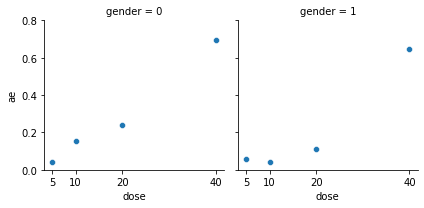

In [48]:
## fraction of patients with AE
### possible effect of gender
y = data[['ae','dose', 'gender']].groupby(['dose', 'gender'])['ae'].mean()
y = pd.DataFrame(y).reset_index()

frac = sns.FacetGrid(y, col='gender')
frac.map(sns.scatterplot, 'dose', 'ae')

plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
plt.xticks(data['dose'].unique())
plt.show()
# plt.plot(dose, y, 'C0.', ms=14)

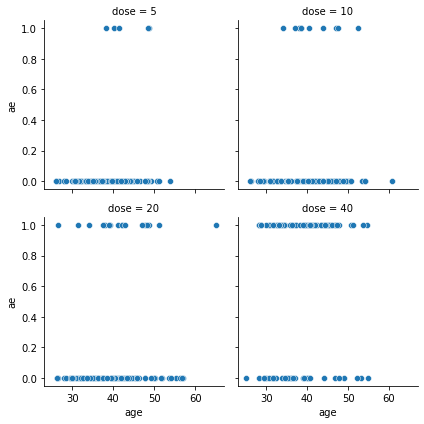

In [42]:
### possible effect of age
y = data[['age','dose','ae']]

frac = sns.FacetGrid(y, col='dose', col_wrap=2)
frac.map(sns.scatterplot, 'age', 'ae')

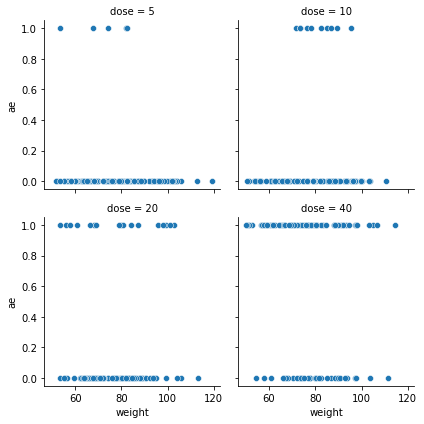

In [52]:
### possible effect of weight
y = data[['weight','dose','ae']]

frac = sns.FacetGrid(y, col='dose', col_wrap=2)
frac.map(sns.scatterplot, 'weight', 'ae')

In [24]:
ae = data['ae'].values

# dose = pd.Categorical(data['dose']).codes
dose = data['dose'].values

weight = data['weight'].values
weight_c = weight - 70

age = data['age'].values
age_c = age - 40

gender = data['gender'].values

## Define Model
def model(obs=None):
    # priors
    beta = numpyro.sample('beta', dist.Normal(loc=0, scale=1000), sample_shape=(5,))

    # likelihood
    theta = beta[0] + beta[1]*dose + beta[2]*age_c + beta[3]*weight_c + beta[4]*gender
    # probs = 1/ 1 + jnp.exp(-theta) # probs = jnn.sigmoid(theta)
    # ae = numpyro.sample('ae', dist.Bernoulli(probs=probs), obs=obs)
    ae = numpyro.sample('ae', dist.Bernoulli(logits=theta), obs=obs)

## RUN!
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=5000, num_chains=3, thinning=5, chain_method='sequential')
mcmc.run(random.PRNGKey(123), obs=ae)

sample: 100%|██████████| 9000/9000 [00:00<00:00, 13515.00it/s, 15 steps of size 3.07e-01. acc. prob=0.92]


In [27]:
## parameter posterior summary
az.summary(mcmc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-3.120,0.362,-3.780,-2.433,0.007,0.005,2944.0,2778.0,1.0
beta[1],0.112,0.012,0.091,0.135,0.000,0.000,2938.0,2793.0,1.0
beta[2],0.052,0.021,0.014,0.090,0.000,0.000,3184.0,2880.0,1.0
beta[3],-0.021,0.011,-0.043,-0.001,0.000,0.000,2901.0,2951.0,1.0
beta[4],-0.833,0.319,-1.432,-0.228,0.006,0.004,3044.0,2806.0,1.0


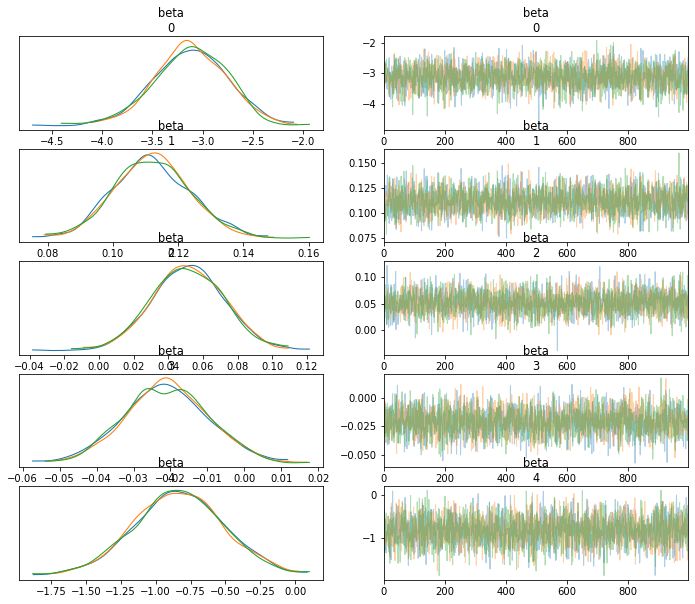

In [26]:
## trace plot
az.plot_trace(mcmc, compact=False)
plt.show()

In [35]:
## get posterior prediction of AE occurance 
pred = Predictive(model=mcmc.sampler.model, posterior_samples=mcmc.get_samples(), return_sites=['ae'])
ae_pred = pred(random.PRNGKey(123))
ae_post = ae_pred['ae']

In [46]:
## data wrangling
post_df = pd.DataFrame(ae_post.T)
post_df['dose'] = dose
## calculate posterior AE probs for each subject
post_df = post_df.groupby('dose').mean().unstack().reset_index()
post_df.columns = ['dose_ind', 'dose', 'ae_prob']
post_df_sub = post_df.sample(frac=0.1)

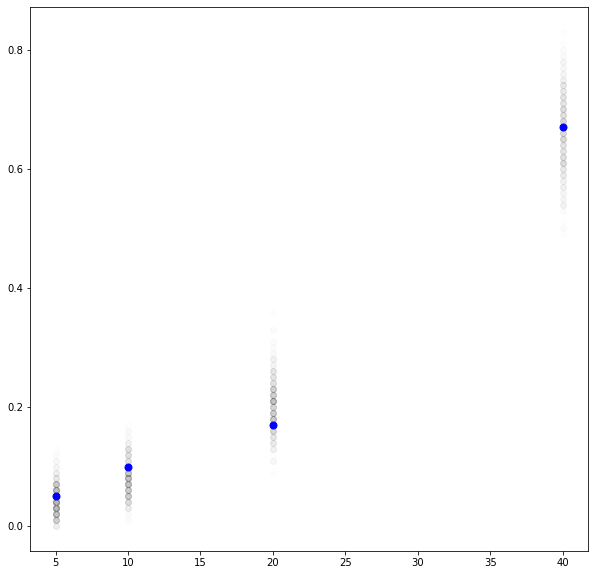

In [60]:
plt.figure(figsize=(10,10))
## the posterior probability of AE occurance for each dose cohort
plt.scatter(post_df_sub['dose'], post_df_sub['ae_prob'], color='grey', alpha=0.01)

## calculate and plot AE probs for each dose cohort
y = data[['ae','dose']].groupby('dose').mean()
y = y.unstack().reset_index()
y.columns = ['ae', 'dose', 'ae_probs']

plt.plot(y['dose'], y['ae_probs'], 'o', color='blue', ms=7)

In [52]:
y = data[['ae','dose']].groupby('dose').mean()
y = y.unstack().reset_index()
y.columns = ['ae', 'dose', 'ae_probs']
y

,ae,dose,ae_probs
0,ae,5,0.05
1,ae,10,0.10
2,ae,20,0.17
3,ae,40,0.67


In [68]:
## data wrangling
post_df = pd.DataFrame(ae_post.T)
post_df['dose'] = dose
post_df['gender'] = gender
## calculate posterior AE probs for each subject
post_df = post_df.groupby(['dose','gender']).mean().unstack().unstack().reset_index()
post_df.columns = ['ind', 'gender', 'dose', 'ae_probs']

post_df_sub = post_df.sample(frac=0.1)

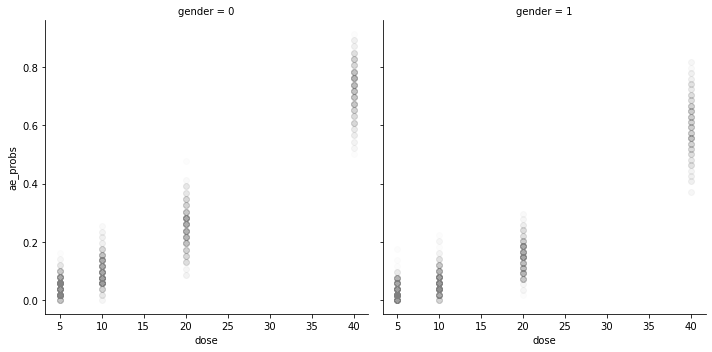

In [106]:
post_grid = sns.FacetGrid(post_df_sub, col='gender', height=5)
post_grid.map(plt.scatter, 'dose', 'ae_probs', color='grey', alpha=0.02)


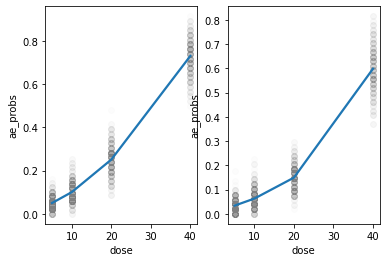

In [105]:
_, ax = plt.subplots(1,2, figsize=(6,12))
for i in range(2):
    data = post_df_sub[post_df_sub['gender']==(i)]
    ax[i].scatter(data['dose'], data['ae_probs'], color='grey',alpha=0.02)
    sns.regplot(ax=ax[i], x=data['dose'], y=data['ae_probs'], lowess=True, scatter=False)


### Binomial Model for Summary Data

This is the nausea example in MI255 Lec2. A nonlinear logistic regression model is used to model nausea occurrence in the ith dose cohort.

$$n_{nausea,i} \sim Binomial(p_{nausea,i}, n_i)$$
$$logit(p_{nausea,i} = \alpha + \beta * dose_i^{\gamma}$$
$$\alpha \sim Normal(0, 10^6)$$
$$\beta \sim  Normal(0, 10^6)$$
$$\gamma \sim Uniform(0.1, 10)$$

In [7]:
data = pd.DataFrame({
    'dose': [0, 50, 100, 200, 400],
    'n_nausea': [64, 70, 110, 111, 130],
    'n_patients': [636, 317, 424, 307, 317]
})

data['perc_nausea'] = data['n_nausea'] / data['n_patients']
data['log_perc_nausea'] = np.log(data['perc_nausea'])
data

,dose,n_nausea,n_patients,perc_nausea,log_perc_nausea
0,0,64,636,0.100629,-2.296315
1,50,70,317,0.220820,-1.510407
2,100,110,424,0.259434,-1.349253
3,200,111,307,0.361564,-1.017318
4,400,130,317,0.410095,-0.891367


Text(0, 0.5, 'log(faction of patients with nausea)')

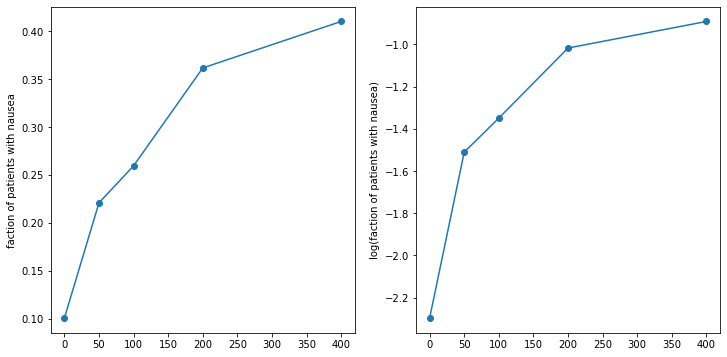

In [19]:
##plot faction of patients wiht nausea
_, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(data['dose'], data['perc_nausea'], 'C0.-', ms=12)
ax[0].set_ylabel('faction of patients with nausea')
ax[1].plot(data['dose'], np.log(data['perc_nausea']), 'C0.-', ms=12)
ax[1].set_ylabel('log(faction of patients with nausea)')

In [42]:
n_patients = data['n_patients'].values
nausea_obs = data['n_nausea'].values
dose = data['dose'].values

## Define Model:
def model(obs=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(loc=0, scale=10**6))
    beta  = numpyro.sample('beta',  dist.Normal(loc=0, scale=10**6))
    gamma = numpyro.sample('gamma', dist.Uniform(low=0.01, high=10))

    # likelihood
    logit_p = alpha + beta * (dose ** gamma)
    n_nausea = numpyro.sample('n_nausea', dist.Binomial(total_count=n_patients,logits=logit_p), obs=obs)

kernel = NUTS(model)
mcmc2 = MCMC(kernel, num_warmup=3000, thinning=5, num_samples=3000, num_chains=3, chain_method='sequential')
mcmc2.run(random.PRNGKey(321), obs=nausea_obs)

sample: 100%|██████████| 6000/6000 [00:00<00:00, 17412.45it/s, 63 steps of size 6.96e-02. acc. prob=0.94]


In [43]:
az.summary(mcmc2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-2.215,0.129,-2.452,-1.979,0.003,0.002,1424.0,1703.0,1.0
beta,0.313,0.112,0.126,0.521,0.003,0.002,1149.0,1566.0,1.0
gamma,0.309,0.060,0.207,0.434,0.002,0.001,1173.0,1368.0,1.0


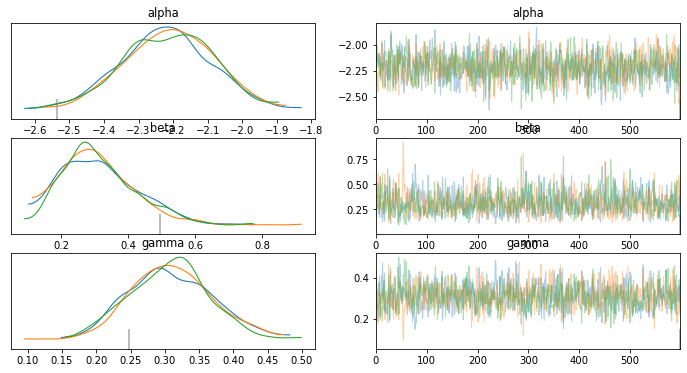

In [44]:
az.plot_trace(mcmc2, compact=False)
plt.show()

In [45]:
pred = Predictive(model=mcmc2.sampler.model, posterior_samples=mcmc2.get_samples(),
                    return_sites=['n_nausea'])
nausea_post = pred(random.PRNGKey(12))
nausea_post

{'n_nausea': DeviceArray([[ 56,  62,  98,  91, 150],
              [ 68,  70, 115, 108, 137],
              [ 71,  79, 112, 107, 127],
              ...,
              [ 55,  57, 122, 110, 147],
              [ 69,  64, 110,  92, 127],
              [ 48,  79,  98,  96, 136]], dtype=int32)}

In [98]:
nausea_probs = nausea_post['n_nausea'] / n_patients[jnp.newaxis ,:]
nausea_probs_df = pd.DataFrame(nausea_probs, columns=dose)
nausea_probs_df = nausea_probs_df.unstack().reset_index()
nausea_probs_df.columns = ['dose', 'ind', 'nause_probs']
nausea_probs_df['log_probs'] = nausea_probs_df['nause_probs'].apply(np.log)
nausea_probs_df.head()

,dose,ind,nause_probs,log_probs
0,0,0,0.088050,-2.429847
1,0,1,0.106918,-2.235691
2,0,2,0.111635,-2.192519
3,0,3,0.099057,-2.312064
4,0,4,0.130503,-2.036358


Text(0, 0.5, 'log(faction of patients with nausea)')

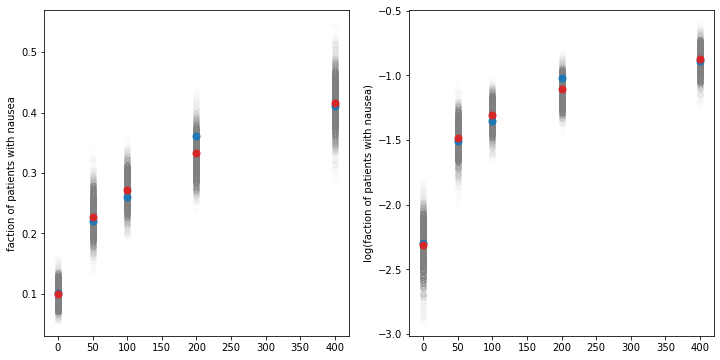

In [114]:
_, ax = plt.subplots(1,2, figsize=(12,6))

## faction of patients wiht nausea
### nause probability posterior distribution
ax[0].scatter(nausea_probs_df['dose'], nausea_probs_df['nause_probs'], color='grey', alpha=0.01)
### observed nause probability
ax[0].plot(data['dose'], data['perc_nausea'], 'C0.', ms=14)
### nause probability estimate based on posterior distribution
ax[0].plot(dose, nausea_probs_df[['nause_probs', 'dose']].groupby('dose').median()['nause_probs'], 
            'C3.', ms=14)
ax[0].set_ylabel('faction of patients with nausea')

## log faction of patients wiht nausea
ax[1].scatter(nausea_probs_df['dose'], nausea_probs_df['log_probs'], color='grey', alpha=0.01)
ax[1].plot(data['dose'], np.log(data['perc_nausea']), 'C0.', ms=14)
ax[1].plot(dose, nausea_probs_df[['log_probs', 'dose']].groupby('dose').median()['log_probs'], 
            'C3.', ms=14)
ax[1].set_ylabel('log(faction of patients with nausea)')

### Hands-On Problem 1: Logistic Regression for Binary Data

This is the hands-on exercise in MI255 Lab2.

Phase 2 dose-finding trial in CF patients
- parallel design
- 100 patients per dose arm 
- multiple doses of ME-2
- 0, 20, 40, 60 mg qd administered by inhalation for 24 weeks
- primary efficacy measurement: occurrence of >= 1 pulmonary exacerbation event within 24 weeks
- covariates: age, baseline FEV1, concomitant medications

TODO: construct a model for occurrence of pulmanery exacerbation as a functions of dose and possibly patient-specific covariates

PROPOSED MODELS:
- BINOMIAL BASE MODEL:
$$n_{exac,i} \sim Binomial(p_{exac,i}, n_i)$$
$$logit(p_{exac,i} = \beta_0 + \beta_1 * Dose_i$$
$$\beta_i \sim Normal(0, 10^6)$$

- BERNOULLI FULL MODEL:
$$exac_{i} \sim Bernoulli(p_{exac,i})$$
$$logit(p_{exac,i} = \beta_0 + \beta_1 * Dose_i + \beta_2 * FEV1_i + \beta_3 * age_i + \beta_4 * ConMed_i $$
$$\beta_i \sim Normal(0, 10^6)$$

In [171]:
data = pd.read_csv('data/ME2ExacerbationData.csv')
# data['exac_bool'] = data['exac'].astype('bool')
# data[data['exac']==3]
data.head()

,patient,dose,FEV1Baseline,AntiBio,DNase,age,exac
0,1,40,51,0,0,28,0
1,2,60,55,0,1,35,0
2,3,0,73,0,0,20,0
3,4,40,56,0,0,29,0
4,5,20,78,0,0,12,0


In [177]:
## fraction of patients with >= 1 pulmonary exac as a function of dose & AntiBio
data.groupby(['dose', 'AntiBio'])['exac'].agg(('mean', 'sum', 'count'))

mean  sum  count
dose AntiBio                      
0    0        0.448276   26     58
     1        0.380952   16     42
20   0        0.369565   17     46
     1        0.314815   17     54
40   0        0.370370   20     54
     1        0.217391   10     46
60   0        0.312500   15     48
     1        0.134615    7     52

In [178]:
## fraction of patients with >= 1 pulmonary exac as a function of dose & DNase
data.groupby(['dose', 'DNase'])['exac'].agg(('mean', 'sum', 'count'))

mean  sum  count
dose DNase                      
0    0      0.352941   18     51
     1      0.489796   24     49
20   0      0.346939   17     49
     1      0.333333   17     51
40   0      0.285714   14     49
     1      0.313725   16     51
60   0      0.139535    6     43
     1      0.280702   16     57

<AxesSubplot:xlabel='dose', ylabel='exac'>

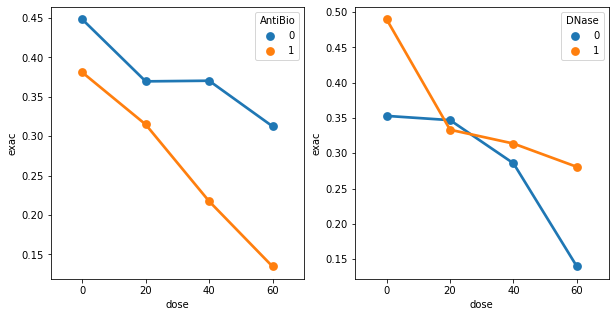

In [172]:
_, ax = plt.subplots(1,2, figsize=(10,5))

y = data.groupby(['AntiBio', 'dose'])['exac'].mean().reset_index()
sns.pointplot(ax=ax[0], x='dose', y='exac', hue='AntiBio', data=y)

y = data.groupby(['dose', 'DNase'])['exac'].mean().reset_index()
sns.pointplot(ax=ax[1], x='dose', y='exac', hue='DNase', data=y)

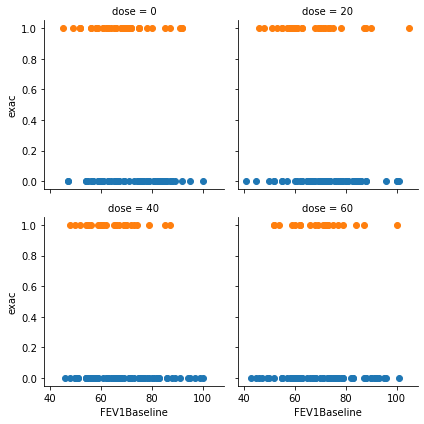

In [180]:
frac = sns.FacetGrid(data, col='dose', hue='exac', col_wrap=2)
frac.map(plt.scatter, 'FEV1Baseline', 'exac')

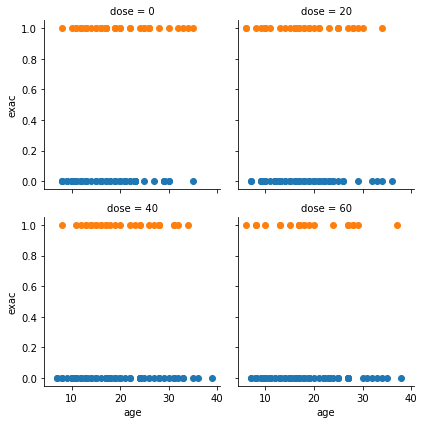

In [181]:
frac = sns.FacetGrid(data, col='dose', hue='exac', col_wrap=2)
frac.map(plt.scatter, 'age', 'exac')

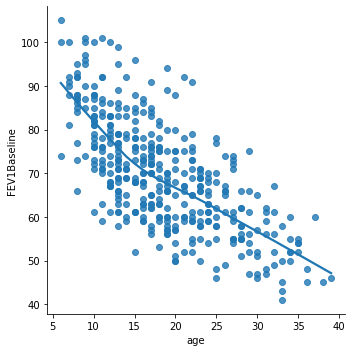

In [187]:
## relationship between age and baseline FEV1
sns.lmplot(data=data, x='age', y='FEV1Baseline', lowess=True)

In [192]:
sum_data = data.groupby(['dose'])['exac'].agg(['sum', 'count']).reset_index()

sum_data

,dose,sum,count
0,0,42,100
1,20,34,100
2,40,30,100
3,60,22,100


In [193]:
sum_data = data.groupby(['dose'])['exac'].agg(['sum', 'count']).reset_index()
dose = sum_data['dose'].values
exac = sum_data['sum'].values

## Modelling: Base Model
def model(obs=None):
    # priors
    beta = numpyro.sample('beta', dist.Normal(loc=0, scale=10**6), sample_shape=(2,))

    # likelihood
    logit_p = beta[0] + beta[1] * dose
    n_exac = numpyro.sample('n_exac', dist.Binomial(total_count=100, logits=logit_p), obs=obs)

kernel = NUTS(model)
mcmc3 = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=3, chain_method='sequential')
mcmc3.run(random.PRNGKey(31), obs=exac)

sample: 100%|██████████| 3000/3000 [00:00<00:00, 22653.50it/s, 3 steps of size 4.13e-01. acc. prob=0.94]


In [194]:
az.summary(mcmc3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.332,0.169,-0.639,-0.003,0.004,0.003,1772.0,1969.0,1.0
beta[1],-0.015,0.005,-0.024,-0.006,0.000,0.000,1891.0,2114.0,1.0


array([[<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n0'}>],
       [<AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'beta\n1'}>]], dtype=object)

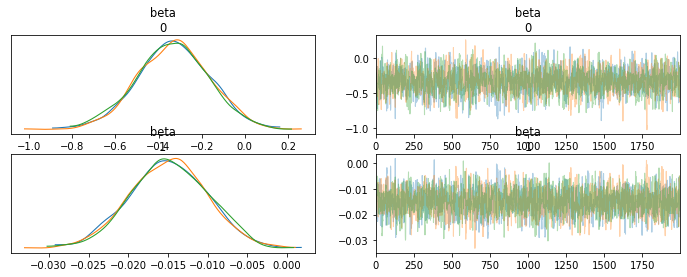

In [195]:
az.plot_trace(mcmc3, compact=False)

In [199]:
pred = Predictive(model=mcmc3.sampler.model, posterior_samples=mcmc3.get_samples(),
                return_sites=['n_exac'])
post_n_exac = pred(random.PRNGKey(12))['n_exac']
post_n_exac

DeviceArray([[52, 38, 34, 21],
             [48, 32, 27, 18],
             [32, 25, 29, 22],
             ...,
             [48, 41, 30, 31],
             [41, 51, 30, 19],
             [43, 34, 24, 27]], dtype=int32)

In [208]:
post_df = pd.DataFrame(post_n_exac, columns=dose).unstack().reset_index()
post_df.columns = ['dose', 'ind', 'n_exac']
post_df = post_df.sample(frac=0.2)

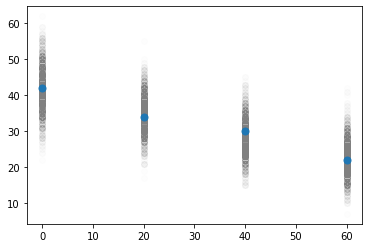

In [209]:

plt.scatter(post_df['dose'], post_df['n_exac'], color='grey', alpha=0.01)

plt.plot(sum_data['dose'], sum_data['sum'], 'C0.', ms=14)

In [210]:
dose = data['dose'].values
FEV1_c = data['FEV1Baseline'].values - 70
antibio = data['AntiBio'].values
dnase = data['DNase'].values
age_c = data['age'].values - 18
exac = data['exac'].values

## Modeling: Full Model
def model(obs=None):
    # priors
    beta = numpyro.sample('beta', dist.Normal(loc=0, scale=10**6), sample_shape=(6,))

    # likelihood
    logit_p = beta[0] + beta[1]*dose + beta[2]*FEV1_c + beta[3]*antibio + beta[4]*dnase + beta[5] * age_c
    exac = numpyro.sample('exac', dist.Bernoulli(logits=logit_p), obs=obs)

kernel = NUTS(model)
mcmc4 = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=3, chain_method='sequential')
mcmc4.run(random.PRNGKey(31), obs=exac)

sample: 100%|██████████| 3000/3000 [00:00<00:00, 11084.96it/s, 15 steps of size 3.39e-01. acc. prob=0.93]


In [211]:
az.summary(mcmc4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.264,0.231,-0.686,0.171,0.003,0.003,4363.0,3965.0,1.0
beta[1],-0.016,0.005,-0.026,-0.007,0.000,0.000,5481.0,4079.0,1.0
beta[2],-0.043,0.013,-0.067,-0.018,0.000,0.000,4185.0,4136.0,1.0
beta[3],-0.571,0.227,-0.990,-0.144,0.003,0.002,4483.0,3665.0,1.0
beta[4],0.370,0.226,-0.053,0.792,0.003,0.002,5071.0,3858.0,1.0
beta[5],-0.030,0.022,-0.071,0.010,0.000,0.000,4213.0,4435.0,1.0


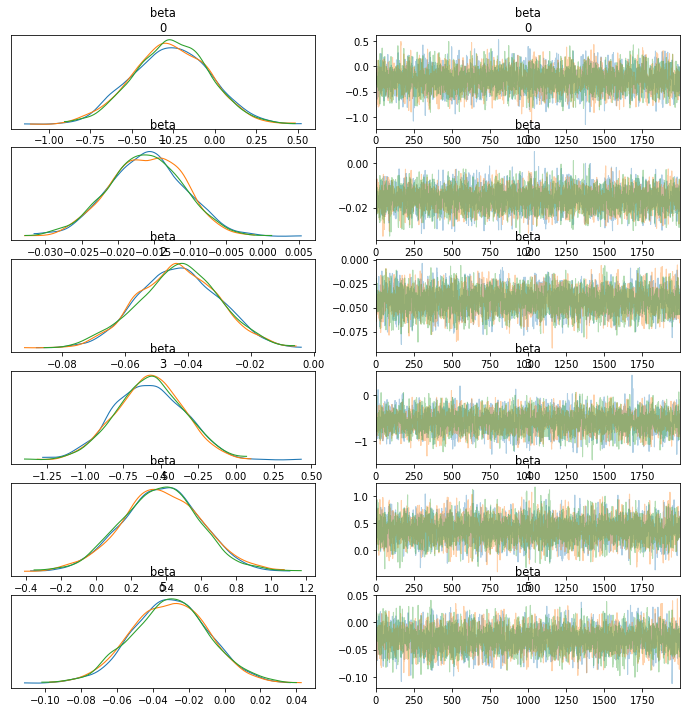

In [213]:
az.plot_trace(mcmc4, compact=False)
plt.show()

In [214]:
pred = Predictive(model=mcmc4.sampler.model, posterior_samples=mcmc4.get_samples(),
                return_sites=['exac'])
exac_post = pred(random.PRNGKey(123))['exac']
exac_post

DeviceArray([[0, 0, 0, ..., 1, 0, 0],
             [0, 1, 0, ..., 1, 1, 0],
             [0, 1, 0, ..., 0, 1, 0],
             ...,
             [1, 0, 1, ..., 1, 1, 1],
             [0, 0, 0, ..., 1, 0, 0],
             [0, 0, 0, ..., 0, 1, 0]], dtype=int32)

In [221]:
post_df = pd.DataFrame(exac_post.T)
post_df['dose']=dose
post_df['antibio'] = antibio
post_df['dnase'] = dnase
antibio_df = post_df.groupby(['dose', 'antibio']).mean().unstack().unstack().reset_index()
antibio_df.columns = ['ind', 'antibio', 'dose', 'exac_probs']

dnase_df = post_df.groupby(['dose', 'dnase']).mean().unstack().unstack().reset_index()
dnase_df.columns = ['ind', 'dnase', 'dose', 'exac_probs']

,ind,dnase,dose,exac_probs
0,0,0,0,0.470588
1,0,0,20,0.346939
2,0,0,40,0.306122
3,0,0,60,0.279070
4,0,1,0,0.510204
...,...,...,...,...
48003,antibio,0,60,0.511628
48004,antibio,1,0,0.387755
48005,antibio,1,20,0.607843
48006,antibio,1,40,0.431373


<AxesSubplot:xlabel='dose', ylabel='exac'>

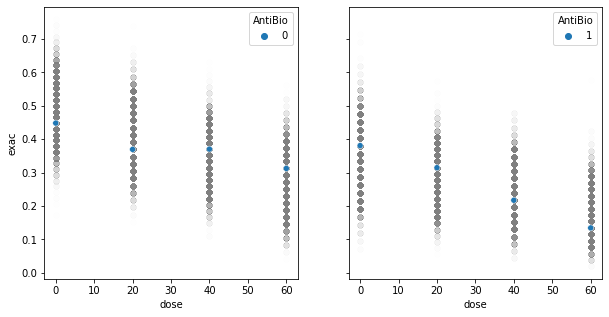

In [239]:
_, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)

ax[0].scatter(x=antibio_df.loc[antibio_df['antibio']==0]['dose'],
              y=antibio_df.loc[antibio_df['antibio']==0]['exac_probs'],
              color='grey', alpha=0.005)

ax[1].scatter(x=antibio_df.loc[antibio_df['antibio']==1]['dose'],
              y=antibio_df.loc[antibio_df['antibio']==1]['exac_probs'],
              color='grey', alpha=0.005)

y = data.groupby(['AntiBio', 'dose'])['exac'].mean().reset_index()
sns.scatterplot(ax=ax[0], x='dose', y='exac', hue='AntiBio', data=y.loc[y.AntiBio == 0])
sns.scatterplot(ax=ax[1], x='dose', y='exac', hue='AntiBio', data=y.loc[y.AntiBio == 1])

<AxesSubplot:xlabel='dose', ylabel='exac'>

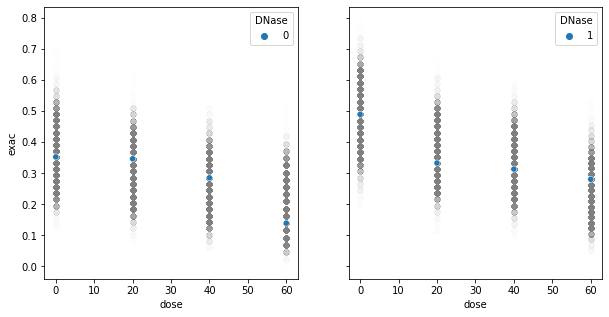

In [240]:
_, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)

ax[0].scatter(x=dnase_df.loc[dnase_df['dnase']==0]['dose'],
              y=dnase_df.loc[dnase_df['dnase']==0]['exac_probs'],
              color='grey', alpha=0.005)

ax[1].scatter(x=dnase_df.loc[dnase_df['dnase']==1]['dose'],
              y=dnase_df.loc[dnase_df['dnase']==1]['exac_probs'],
              color='grey', alpha=0.005)

y = data.groupby(['DNase', 'dose'])['exac'].mean().reset_index()
sns.scatterplot(ax=ax[0], x='dose', y='exac', hue='DNase', data=y.loc[y.DNase == 0])
sns.scatterplot(ax=ax[1], x='dose', y='exac', hue='DNase', data=y.loc[y.DNase == 1])